# Getting the Jets

In [1]:
from servicex import dataset, deliver
from func_adl_servicex_xaodr21 import FuncADLQueryPHYS
from servicex_analysis_utils import to_awk
import matplotlib.pyplot as plt
import awkward as ak

Lets use an old dataset that I'm used to using. Some of these jets are "weird", but this will do for now.

In [2]:
ds = dataset.Rucio(
    # "mc16_13TeV:mc16_13TeV.311311.MadGraphPythia8EvtGen_A14NNPDF31LO_HSS_LLP_mH125_mS15.deriv.DAOD_EXOT15.e7270_s3234_r9364_p4696",
    "mc16_13TeV:mc16_13TeV.364702.Pythia8EvtGen_A14NNPDF23LO_jetjet_JZ2WithSW.deriv.DAOD_PHYS.e7142_s3126_r9364_r9315_p5313",
    num_files=1,
)

In [3]:
jet_query = FuncADLQueryPHYS().Select(lambda e: e.Jets(calibrate=False)).Select(lambda jets: {
    "pt_uncor": [j.pt() for j in jets],
    "eta_uncor": [j.eta() for j in jets],
    "phi_uncor": [j.phi() for j in jets],
})

data = to_awk(deliver({"Sample": [{"Name": "r21_125_15", "Dataset": ds, "Query": jet_query}]}))

Output()

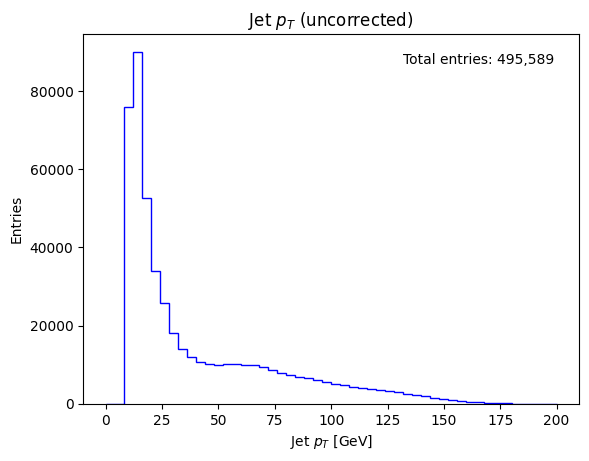

In [17]:
# Convert pt_uncor from MeV to GeV and flatten the array
pt_uncor_gev = data['r21_125_15'].pt_uncor / 1000
pt_uncor_gev_flat = ak.flatten(pt_uncor_gev)

# Plot histogram
plt.hist(pt_uncor_gev_flat, bins=50, histtype='step', color='blue', range=(0, 200))
plt.xlabel('Jet $p_T$ [GeV]')
plt.ylabel('Entries')
plt.title('Jet $p_T$ (uncorrected)')

# Annotate with total number of entries
total_entries = len(pt_uncor_gev_flat)
plt.text(0.95, 0.95, f'Total entries: {total_entries:,}', ha='right', va='top', transform=plt.gca().transAxes)

plt.show()

In [5]:
jet_query_corrected = (
    FuncADLQueryPHYS()
    .Select(lambda e: e.Jets())
    .Select(
        lambda jets: {
            "pt_uncor": [j.pt() for j in jets],
            "eta_uncor": [j.eta() for j in jets],
            "phi_uncor": [j.phi() for j in jets],
        }
    )
)

data_corrected = to_awk(
    deliver(
        {
            "Sample": [
                {"Name": "r21_125_15", "Dataset": ds, "Query": jet_query_corrected}
            ]
        }
    )
)

Output()

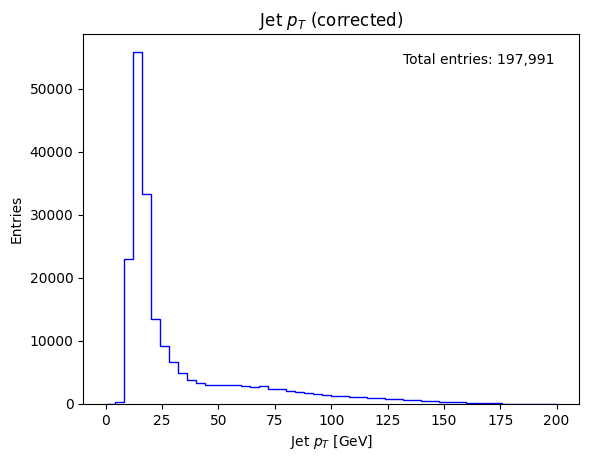

In [16]:
# Convert pt_uncor from MeV to GeV and flatten the array
pt_cor_gev = data_corrected["r21_125_15"].pt_uncor / 1000
pt_cor_gev_flat = ak.flatten(pt_cor_gev)

# Plot histogram
plt.hist(pt_cor_gev_flat, bins=50, histtype="step", color="blue", range=(0, 200))
plt.xlabel("Jet $p_T$ [GeV]")
plt.ylabel("Entries")
plt.title("Jet $p_T$ (corrected)")

# Annotate with total number of entries
total_entries = len(pt_cor_gev_flat)
plt.text(
    0.95,
    0.95,
    f"Total entries: {total_entries:,}",
    ha="right",
    va="top",
    transform=plt.gca().transAxes,
)

plt.show()

Note the two have different numbers of jets. This is because there are cuts that a jet must survive (quality, etc.) before the correction can be applied.

So, to compare the jets, one must apply the $\Delta R^2 = \Delta\eta^2 + \Delta\phi^2$ selection - jets with a very small $\Delta R$ (like less than 0.05) are likely the same jet. You can use that to match jets.

* Lucas - just use the corrected jets (no matching required!)
* Cole - you'll need to use both, and the matching.